### Score = 0.83138


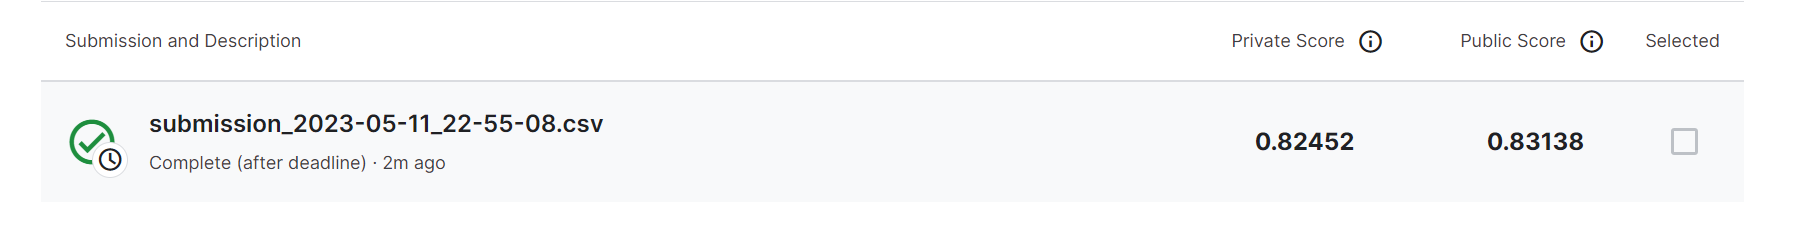

# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [ ]:
# !pip install Cython

In [5]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
# import Cython
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from catboost import CatBoostClassifier

%matplotlib inline

In [6]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/BI/bi-ml-competition-2023.zip'

Archive:  /content/drive/MyDrive/BI/bi-ml-competition-2023.zip
  inflating: test_data.csv           
  inflating: test_raw_data.jsonl     
  inflating: train_data.csv          
  inflating: train_raw_data.jsonl    
  inflating: train_targets.csv       


In [8]:
PATH_TO_DATA = "./"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [9]:
df_train_features.shape

(31698, 245)

In [10]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [11]:
cat_features = ['game_mode', 'lobby_type', 
                'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 
                'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
                'r1_firstblood_claimed', 'r2_firstblood_claimed', 'r3_firstblood_claimed', 'r4_firstblood_claimed', 'r5_firstblood_claimed',
                'd1_firstblood_claimed', 'd2_firstblood_claimed', 'd3_firstblood_claimed', 'd4_firstblood_claimed', 'd5_firstblood_claimed']

In [12]:
cat_feature_names = ['hero_id', 'firstblood_claimed']
num_feature_names = ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 
                     'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked',
                     'camps_stacked', 'rune_pickups', 'teamfight_participation', 'towers_killed',
                     'roshans_killed', 'obs_placed', 'sen_placed']

def add_max_min_mean(df):
    num_feature_names.append('KDA')
    for team in ['r', 'd']:
            
        for i in range(1, 6):
            df[f'{team}{i}_KDA'] = (df[f'{team}{i}_kills'] + df[f'{team}{i}_assists']) / (df[f'{team}{i}_deaths'] + 1)
        
        for feature in num_feature_names:
            col_names = [f'{team}{i}_{feature}' for i in range(1, 6)]
            df[f'{team}_{feature}_max'] = np.max(df[col_names], axis=1)
            df[f'{team}_{feature}_min'] = np.min(df[col_names], axis=1)
            df[f'{team}_{feature}_mean'] = np.mean(df[col_names], axis=1)
#             df.drop(columns=col_names, inplace=True)
        
    return df

In [13]:
df_train_features = add_max_min_mean(df_train_features)
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d_roshans_killed_mean,d_obs_placed_max,d_obs_placed_min,d_obs_placed_mean,d_sen_placed_max,d_sen_placed_min,d_sen_placed_mean,d_KDA_max,d_KDA_min,d_KDA_mean
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,4,0,1.0,2,0,0.4,0.5,0.000000,0.295238
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0,0,0.0,0,0,0.0,0.0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.0,0,0,0.0,0,0,0.0,0.0,0.000000,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.0,3,0,1.4,1,0,0.2,4.0,0.800000,2.026667
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0.0,3,0,0.8,1,0,0.2,5.0,0.666667,2.266667


Была интересная идея:
Сортировать игроков по KDA, таким образом фичи, которые относятся к игроку номер 1, означали бы не просто случайного игрока, а самого "скиллового". 
Но, как ни странно, качество это не повысило, а выполнялось крайне долго :(

In [14]:
# def sorting(x):
#     x_copy = x.copy()
#     for team in ['r', 'd']:
#         kda_names = [f'{team}{i}_KDA' for i in range(1, 6)] 
#         ranks = np.argsort(-x[kda_names]) + 1

#         for i in range(1, 6):
#             for feature in num_feature_names + cat_feature_names + ['KDA']:
#                 x[f'{team}{i}_{feature}'] = x_copy[f'{team}{ranks[i - 1]}_{feature}']
#     return x

# df_train_features.apply(sorting, axis=1)

Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [15]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [16]:
X = df_train_features #.values
y = df_train_targets["radiant_win"] #.values.astype("int8")

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [18]:
# %%time
# rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
# rf_model.fit(X_train, y_train)

#### Попробуем catboost

In [19]:
model = CatBoostClassifier(cat_features=cat_features, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_valid)[:, 1]

#### Сделаем предсказания и оценим качество на отложенной части данных

In [20]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.8099119461643292


Посмотрим на accuracy:

In [21]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.7231335436382755


## <left>Посылка

Обучимся на вскй доступной выборке и сделаем предсказание

In [22]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")
df_test_features = add_max_min_mean(df_test_features)
X_test = df_test_features
model.fit(X, y)
y_test_pred = model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [23]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-05-11_21-58-25.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [24]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [25]:
%%time
model = CatBoostClassifier(cat_features=cat_features, verbose=False)
cv_scores_rf = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 23min 3s, sys: 1min 31s, total: 24min 34s
Wall time: 14min 52s


In [26]:
cv_scores_rf

array([0.80991195, 0.81446523, 0.80677099, 0.81212198, 0.8131321 ])

In [27]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8112804494992133


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [28]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [29]:
match['game_time']

2049

In [30]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [31]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [32]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

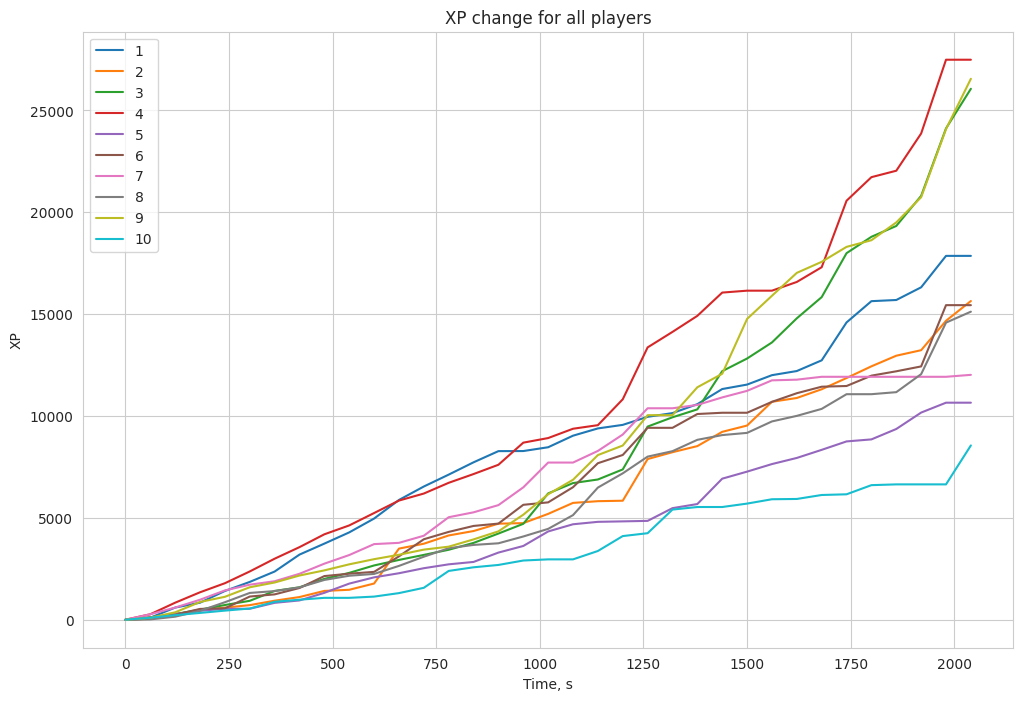

In [33]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [34]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [35]:
len(match['teamfights'])

5

In [36]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        df_features.loc[match_id_hash, "teamfights"] = len(match['teamfights'])
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
    
    return df_features

In [37]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
df_train_features_extended = add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [38]:
np.all(df_train_features_extended.index == df_train_targets.index)

True

In [39]:
X = df_train_features_extended
y = df_train_targets["radiant_win"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [40]:
model = CatBoostClassifier(cat_features=cat_features, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_valid)[:, 1]

In [41]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)
print('check')

ROC-AUC score на отложенной части: 0.8106838985092442
check


In [42]:
%%time
model = CatBoostClassifier(cat_features=cat_features, verbose=False)

cv_scores_base = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(model, df_train_features_extended, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 10.4 s, sys: 1.32 s, total: 11.7 s
Wall time: 29min 52s


In [43]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.8124853408434604
ROC-AUC на кросс-валидации для новых признаков: 0.8124853408434604


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

In [44]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

df_test_features = add_max_min_mean(df_test_features)
df_test_features_extended = df_test_features.copy()

In [48]:
# Добавим новые
df_test_features_extended = add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [49]:
X_test = df_test_features_extended
model.fit(X, y, cat_features=cat_features)

In [50]:
y_test_pred = model.predict_proba(X_test)[:, 1]

In [51]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [52]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-05-11_22-55-08.csv
